# 라이브러리 Import 및 환경 설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import argparse, yaml
from addict import Dict

import kagglehub


print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

PyTorch Version:  2.5.1+cu121
Torchvision Version:  0.20.1+cu121
Pillow Version:  11.1.0
CUDA is available!  Training on GPU ...


### config 변수 불러오기

In [2]:
#config 불러오기
def get_cfg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="config.yaml")
    args, _ = parser.parse_known_args()

    # args.config 에 지정된 YAML 파일 읽어서 Dict 형태로 반환
    with open(args.config) as f:
        cfg = Dict(yaml.safe_load(f))
    return cfg

cfg = get_cfg()

In [3]:
#전역 시드 고정

def set_global_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

In [4]:
set_global_seed(cfg.seed) 

### config 변수 불러오기

In [5]:
# random seed
seed            = cfg.seed
# train_split ratio
train_split     = cfg.data.train_split
# train_split random seed
random_state    = cfg.data.random_state
batch_size      = cfg.data.batch_size
num_workers     = cfg.data.num_workers
input_size      = cfg.data.input_size

model_name      = cfg.model.name
pretrained      = cfg.model.pretrained
# feature_extract = False - 전체 모델 학습
# feature_extract = True - Fc 레이어만 학습
feature_extract = cfg.model.feature_extract

optimizer_name  = cfg.training.optimizer
lr              = cfg.training.lr
momentum        = cfg.training.momentum
weight_decay    = cfg.training.weight_decay
scheduler_type  = cfg.training.scheduler
step_size       = cfg.training.step_size
gamma           = cfg.training.gamma
num_epochs          = cfg.training.epochs

random_flip     = cfg.augmentation.random_flip
color_jitter    = cfg.augmentation.color_jitter
cutmix          = cfg.augmentation.cutmix

# 데이터 가져오기

In [6]:
# Download latest version
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\alscj\.cache\kagglehub\datasets\alexattia\the-simpsons-characters-dataset\versions\4


In [ ]:
train_dir = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset')
test_dir = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset')

In [8]:
class TrainValTestSplit():

  def __init__(self, train_dir, test_dir):

    self.train_dir = train_dir
    self.test_dir = test_dir
    # 하위 디렉토리를 순회하며 이미지의 경로를 리스트로 저장
    self.train_val_files_path = sorted(list(self.train_dir.rglob('*.jpg')))
    self.test_path = sorted(list(self.test_dir.rglob('*.jpg')))
    self.train_val_labels = [path.parent.name for path in self.train_val_files_path]

  def get_path(self):

    train_files_path, val_files_path = train_test_split(self.train_val_files_path, test_size = 0.3, \
                                          stratify=self.train_val_labels, random_state = 42)

    train_val_files_path = {'train': train_files_path, 'val': val_files_path}

    return train_val_files_path, self.test_path

  def get_n_classes(self):
    return len(np.unique(self.train_val_labels))


In [9]:
TrainValTestPath = TrainValTestSplit(train_dir, test_dir)
train_path, test_path = TrainValTestPath.get_path()

## 모델 학습 함수

In [10]:
def train_model(model, dataloaders, criterion, optimizer, save_best_weights_path, save_last_weights_path, num_epochs=cfg.training.epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # train과 val 단계에 따라 model 모드 변경
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # train 모드라면 hitstory 저장
                with torch.set_grad_enabled(phase == 'train'):
                    # inception module을 사용하는 모델인경우 loss 설정
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimizer train mode
                    # scheduler의 경우 일단 비활성화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()
                        #lr_step = optimizer_ft.state_dict()["param_groups"][0]["lr"]
                        #lr_find_lr.append(lr_step)

                # 현재 에포크의 손실 저장
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
            
            # loss, acc 계산
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 현재 epoch의 정확도가 best_acc 보다 큰 경우 best 모델을 변경
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # best model 저장장
                torch.save(best_model_wts, save_best_weights_path)
            # 현재 epoch의 정확도를 history에 저장
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc.item())
                train_loss_history.append(epoch_loss)
        
        torch.save(model.state_dict(), save_last_weights_path)
        print()

    # 학습시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # best model 로드
    model.load_state_dict(best_model_wts)

    history_val = {'loss': val_loss_history, 'acc': val_acc_history}
    history_train = {'loss': train_loss_history, 'acc': train_acc_history}
    
    return model, history_val, history_train, time_elapsed, best_acc

## transfer learning 시 동작 결정 함수

In [11]:
# feature_extracting이 설정된 경우 fc레이어의 param만 학습
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## torch.models로부터 모델을 불러오는 함수

In [12]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained):
    
    model_ft = None
       
    if model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        # feature_extract=true인 경우 마지막 fc레이어의 param만 학습
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        # fc레이어의 output 개수 설정
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "resnet18":
        """ Resnet152
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        # feature_extract=true인 경우 마지막 fc레이어의 param만 학습
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        # fc레이어의 output 개수 설정
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

## 데이터셋 클래스

In [13]:
class SimpsonsDataset(Dataset):

    def __init__(self, files_path, data_transforms):
      self.files_path = files_path
      self.transform = data_transforms
      
      if 'test' not in str(self.files_path[0]):
        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        
        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):

      img_path = str(self.files_path[idx]) 
      image = Image.open(img_path)
      image = self.transform(image)
      
      if 'test' in str(self.files_path[0]):
        return image
      else: 
        label_str = str(self.files_path[idx].parent.name)
        label = self.label_encoder.transform([label_str]).item()
        
        return image, label

# 모델 설정

In [14]:
#fc_layer = 'all-st-SGD-m.9-nest-s-cycle-exp-.00001-.05-g.99994-m.8-.9'

# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 가중치 저장
save_last_weights_path = '/kaggle/working/' + model_name + '-' + '_last_weights.pth'
save_best_weights_path = '/kaggle/working/' + model_name + '-' + '_best_weights.pth'

num_classes = TrainValTestPath.get_n_classes()

model_ft = initialize_model(model_name, num_classes, feature_extract, pretrained)

model_ft = model_ft.to(device)

# 데이터 Augmentation

In [15]:
# ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) -> imagenet 데이터셋의 통계 기반
# TODO
# simpson 데이터셋 전체의 std와 mean 계산 후 정규화에 이용

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        #transforms.CenterCrop(input_size),
        transforms.RandomChoice( [
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ColorJitter(contrast=0.9),
                                  transforms.ColorJitter(brightness=0.1),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(contrast=0.9) ], p=0.5),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(brightness=0.1) ], p=0.5),
                                  ] ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 모델에 전달될 데이터 설정

### Dataset

In [16]:
image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}
image_datasets_test = SimpsonsDataset(test_path, data_transforms['val'])

### Dataloader

In [17]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True,
                                                         num_workers=num_workers, worker_init_fn=seed_worker,generator=g),
                    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True,
                                                       num_workers=num_workers,worker_init_fn=seed_worker,generator=g)}
dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=batch_size, shuffle=False,
                                              num_workers=num_workers, worker_init_fn=seed_worker,generator=g)

### 샘플 출력

In [18]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

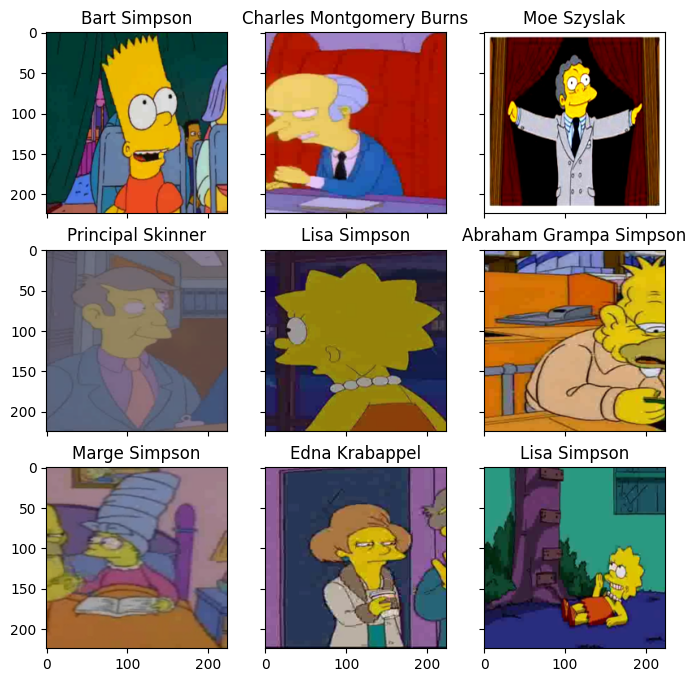

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 4500))
    im_val, label = image_datasets['train'][random_characters]
    # 캐릭터 이름 출력
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# 파라미터 설정

In [20]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

# 학습

학습은
 lr_scheduler.CyclicLR를 이용해 최적의 lr 범위를 찾고
 이를 이용하여 실제 학습하는 두 단계로 이루어짐

## 1. lr 범위 결정

Оптимизацию lr будем проводить используя циклическое изменение его значений в указанном диапазоне. Вначале необходимо определить оптимальные границы диапазона. Для этого проведем тестовый запуск. Выберем step size таким образом, чтобы во время тестового запуска lr линейно возрастал. <br>

После чего построим график accuracy относительно learning rate, на основании графика выберем диапазон значений.

Метод: https://arxiv.org/pdf/1506.01186.pdf

In [21]:
# base_lr = 0.00001
# max_lr = 0.05
# lr_find_epochs = 2

# cost = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9, nesterov = True)

# step_size = lr_find_epochs * len(dataloaders_dict['train'])

# scheduler = optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr = base_lr, max_lr = max_lr, step_size_up=step_size, mode='exp_range', gamma=0.99994, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

# def search_lr(lr_find_epochs):

#   accs = []
#   lr_find_lr = []
#   acc_sum = 0.0

#   for i in range(lr_find_epochs):
#     print("epoch {}".format(i))
#     for inputs, labels in tqdm_notebook(dataloaders_dict['train']):

#       inputs = inputs.to(device)
#       labels = labels.to(device)

#       model_ft.train()
#       optimizer_ft.zero_grad()

#       outputs = model_ft(inputs)
#       loss = cost(outputs, labels)
#       preds = torch.argmax(outputs, 1)
#       acc_running = torch.sum(preds == labels.data).item()
#       acc_sum += torch.sum(preds == labels.data).item()

#       loss.backward()
#       optimizer_ft.step()
#       scheduler.step()

#       lr_step = optimizer_ft.state_dict()["param_groups"][0]["lr"]
#       lr_find_lr.append(lr_step)

#       accs.append(acc_running)
#   accs = np.array(accs) / acc_sum

#   return lr_find_lr, accs

# lr_find_lr, accs = search_lr(lr_find_epochs)

# plt.figure(figsize=(20,10))
# plt.plot(np.array(lr_find_lr), np.array(accs));

## 2. 모델 학습

In [22]:
model_ft = initialize_model(model_name, num_classes, feature_extract=feature_extract, use_pretrained=pretrained)
model_ft = model_ft.to(device)

In [23]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [24]:
#base_lr = 0.0012
#max_lr = 0.0022
#num_epoch = 30

cost = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum, nesterov = True)
#step_size = 2 * math.ceil( len(dataloaders_dict['train']) / batch_size )
#scheduler = optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr = base_lr, max_lr = max_lr, step_size_up=step_size, mode='exp_range', gamma=0.994, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

In [25]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
best_acc = .0

In [26]:
#모델 훈련

total_epochs = cfg.training.epochs 

model_ft, hist_val, hist_train, time_elapsed, best_acc = train_model(
    model_ft,
    dataloaders_dict,
    cost,
    optimizer_ft,
    save_best_weights_path,
    save_last_weights_path,
    num_epochs,
    is_inception=(model_name == "inception")
)

Epoch 0/0
----------


  0%|          | 0/916 [00:00<?, ?it/s]

train Loss: 2.4601 Acc: 0.3239


  0%|          | 0/393 [00:00<?, ?it/s]

val Loss: 1.6587 Acc: 0.5779

Training complete in 2m 25s
Best val Acc: 0.577946


# 학습 결과 및 모델 분석

## 학습 결과 시각화 함수 선언

In [27]:
# train/valid 학습 결과 loss/acc 분류
val_loss = hist_val['loss']
val_acc = hist_val['acc']
train_loss = hist_train['loss']
train_acc = hist_train['acc']

In [28]:
def visualization(train, val, is_loss = True):
  if is_loss:
    plt.figure(figsize=(9,5))
    plt.plot(torch.tensor(train, device =  'cpu'), label = 'Training loss')
    plt.plot(torch.tensor(val, device =  'cpu'), label = 'Val loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  else:
    plt.figure(figsize=(9,5))
    plt.plot(torch.tensor(train, device =  'cpu'), label = 'Training acc')
    plt.plot(torch.tensor(val, device =  'cpu'), label = 'Val acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

## confusion_matrix for val data

In [29]:
def predict(model, test_loader):

    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    
    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs

In [30]:
def confusion_matrix():
    # 실제 label 추출
    actual = [image_datasets['val'][i][1] for i in range(len(image_datasets['val']) ) ]
    
    # 이미지 추출
    image = [image_datasets['val'][i][0] for i in range( len(image_datasets['val']) ) ]
    
    img_conf_dataloader = torch.utils.data.DataLoader(image, batch_size=cfg.data.batch_size, shuffle=False, num_workers=0)

    #image_conf_dataloader의 이미지들의 확률 생성
    probs = predict(model_ft, img_conf_dataloader)
    #가장 높은 확률의 결과로 배열 생성
    preds = np.argmax(probs, axis=1)
    
    # 테이블 생성
    df = pd.DataFrame({'actual': actual, 'preds': preds})
    
    confusion_matrix = pd.crosstab(df['actual'], df['preds'], rownames=['Actual'], colnames=['Predicted'], margins = False)
    
    # 인코더 다운로드 
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    
    # 클래스 목록 가져오기기
    yticklabels = label_encoder.classes_
    
    plt.subplots(figsize=(20,20))

    sn.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", cbar=False, vmax = 30, yticklabels = yticklabels, xticklabels = yticklabels);

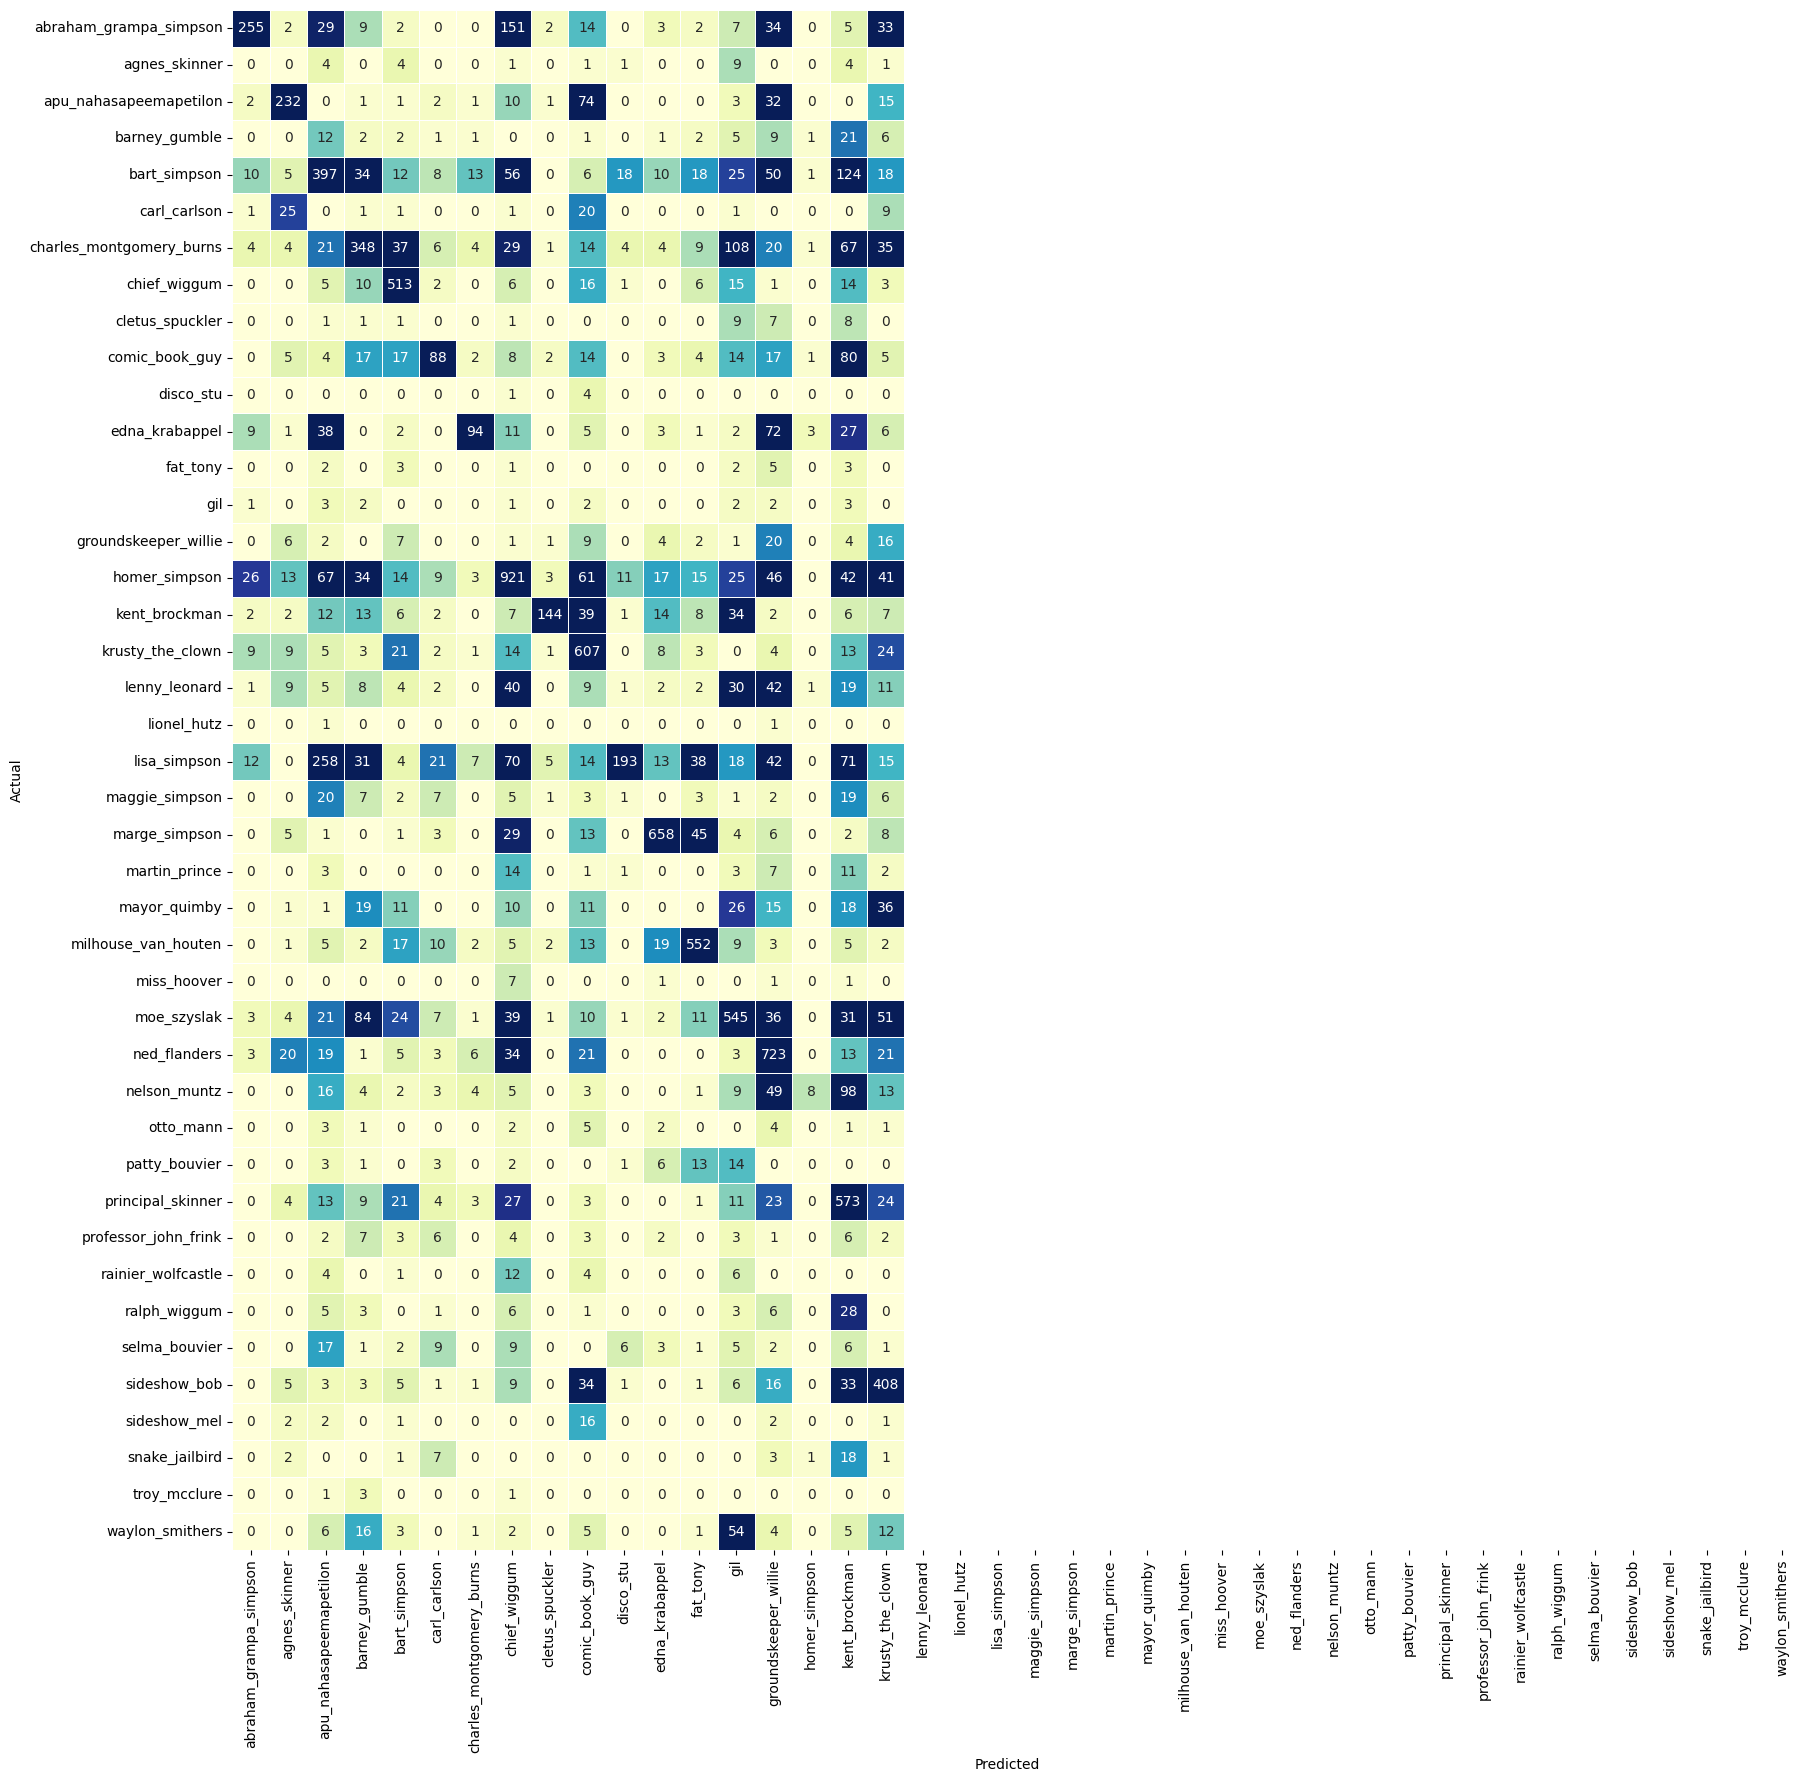

In [31]:
confusion_matrix()

## lr_cycle, acc, loss 시각화

In [ ]:
#plt.figure(figsize=(17,10))
#plt.plot(lr_cycle);

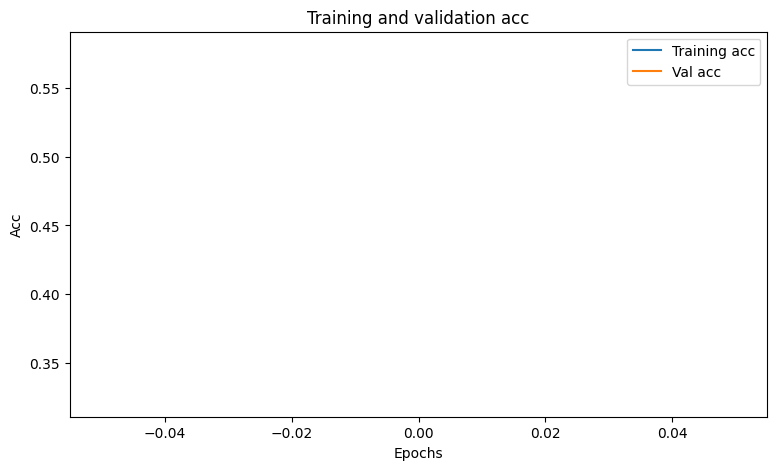

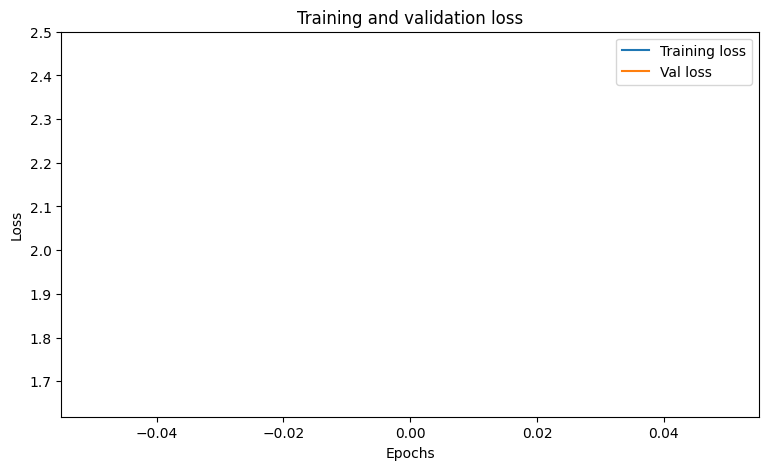

In [32]:
visualization(train_acc, val_acc, is_loss = False)
print('\n')
visualization(train_loss, val_loss, is_loss = True)

# 모델 테스트

## 샘플 테스트

In [33]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

## 테스트 샘플 시각화

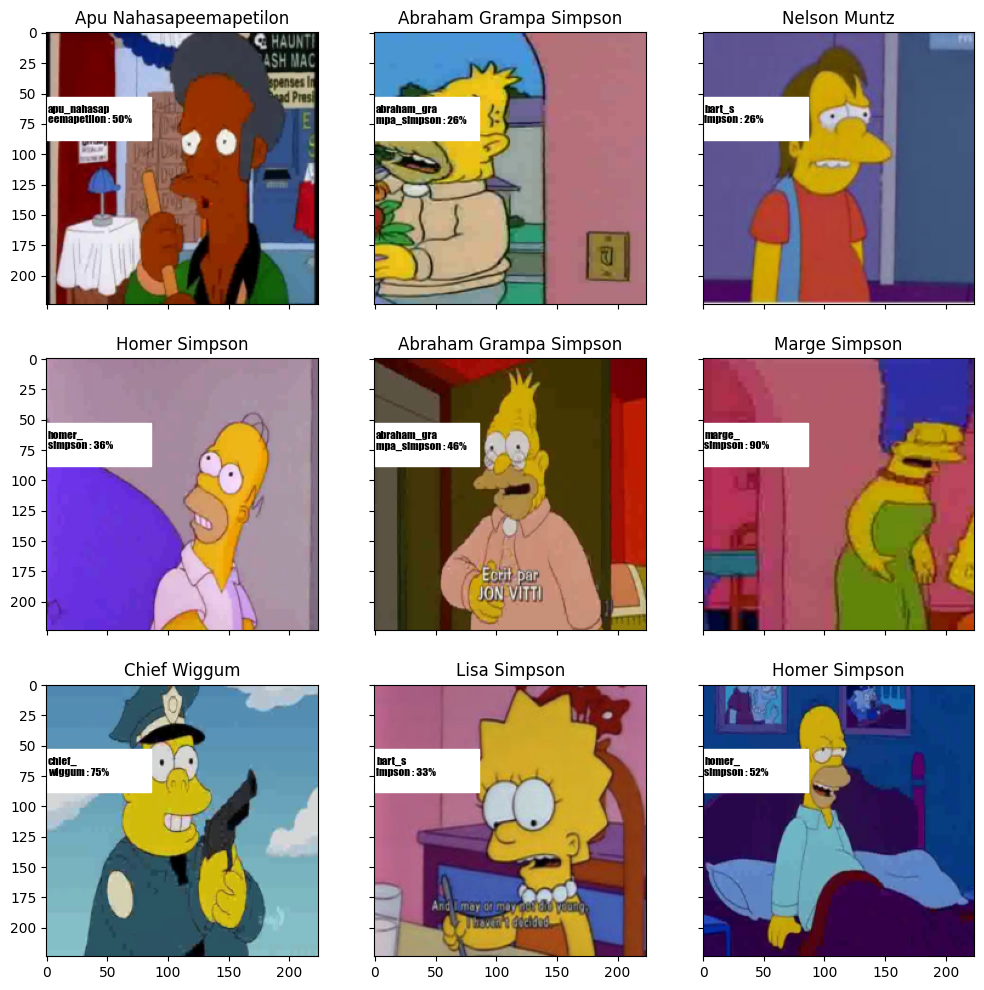

In [34]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), \
                        sharey=True, sharex=True)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = image_datasets['val'][random_characters]
    # inverse_transform은 LabelEncoder() 메서드로, 숫자에서 inverse_transform을 사용하여 클래스 이름을 반환
    # 캐릭터 이름을 가져옴
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)

    # 확률 출력할 영역 추가
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
    # 확률 가져오기
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [35]:
probs = predict(model_ft, dataloader_test)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis = 1 ))
test_file_names = [path.name for path in image_datasets_test.files_path]

for i in range(len(test_file_names)):
  test_file_names[i] = test_file_names[i].split('.')[0].rsplit('_', 1)[0]

present_labels = np.unique(test_file_names)

from sklearn.metrics import classification_report
print(classification_report(test_file_names, preds, labels=present_labels))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.86      0.38      0.52        48
  apu_nahasapeemapetilon       0.85      0.68      0.76        50
            bart_simpson       0.36      0.48      0.41        50
charles_montgomery_burns       0.49      0.44      0.46        48
            chief_wiggum       0.68      0.82      0.75        50
          comic_book_guy       0.62      0.20      0.31        49
          edna_krabappel       0.83      0.30      0.44        50
           homer_simpson       0.40      0.68      0.50        50
           kent_brockman       0.81      0.42      0.55        50
        krusty_the_clown       0.56      0.88      0.69        50
           lenny_leonard       0.00      0.00      0.00        50
            lisa_simpson       0.69      0.18      0.29        50
           marge_simpson       0.91      0.78      0.84        50
            mayor_quimby       0.00      0.00      0.00        50
     milh

In [36]:
#my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
#my_submit.head()
#my_submit.to_csv('simspsons.csv', index=False)